In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math

In [2]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device
device=set_device()

In [3]:
batch_size = 64

In [4]:
path = "../Datasets/dataset_20_classes"
dataset = datasets.ImageFolder(root=path,transform = transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(dataset = dataset,batch_size=batch_size,shuffle=False)

In [5]:
root=pathlib.Path(path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['.DS_Store', 'Apple_healthy', 'Apple_unhealthy', 'Cherry_healthy', 'Cherry_unhealthy', 'Grape_healthy', 'Grape_unhealthy', 'Mango_healthy', 'Mango_unhealthy', 'Peach_healthy', 'Peach_unhealthy', 'Pepperbell_healthy', 'Pepperbell_unhealthy', 'Pomegranate_healthy', 'Pomegranate_unhealthy', 'Potato_healthy', 'Potato_unhealthy', 'Strawberry_healthy', 'Strawberry_unhealthy', 'Tomato_healthy', 'Tomato_unhealthy']


In [6]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [7]:
def transform(dataset):
    data_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True)
    mean,std=get_mean_std(data_loader)
    data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    return data_set

In [8]:
dataset = transform(path)

In [9]:
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset)-train_size-val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size,test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=False, num_workers=0)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
print(str(train_size)+" "+str(val_size)+" "+str(test_size))

13803 1971 3945


In [10]:
model = models.mobilenet_v2(pretrained=True)
model.to(device)

/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:
optimizer=torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)
criterion=nn.CrossEntropyLoss()
num_epochs=50
batch_size = batch_size
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)

In [12]:
train_count = len(train_dataset)
test_count = len(test_dataset)
val_count = len(val_dataset)

In [13]:
import time

In [14]:
n_epochs = 50
epoch_count = 0
Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
total_steps = len(train_loader)
t1 = time.time()
validation_accuracy = 0

In [15]:
for epoch in range(n_epochs):
    print("Epoch: %d "%(epoch+1))
    model.train()
    running_loss=0.0
    running_correct=0.0
    val_loss=0.0
    total=0
    t1 = time.time()
    for i,data in enumerate(train_loader):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        total+=labels.size(0)
        optimizer.zero_grad()
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct+=(labels==predicted).sum().item()
        traning_accuracy=(running_correct/total)*100
    
    validation_accuracy=0
    model.eval()
    with torch.no_grad():
        val_correct=0
        val_total=0
        val_loss=0
        for data in val_loader:
            images,val_labels=data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs=model(images)
            loss_val=criterion(outputs,val_labels)
            val_loss+= loss_val.item()
            _,predicted=torch.max(outputs.data,1)
            val_correct+=(predicted == val_labels).sum().item()
            val_total+=val_labels.size(0)
        validation_accuracy = (val_correct / val_total) *100
    
    scheduler.step()
    epoch_loss=running_loss/len(train_loader)
    val_loss=val_loss/len(val_loader)
    epoch_accuracy=100.00* running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    print("######## epoch Finished in {} seconds ###########".format(time.time()\
                                                                    -t1))
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f, Validation Accuracy: %.3f"%(epoch_loss,epoch_accuracy,val_loss,validation_accuracy))
    
        

Epoch: 1 
######## epoch Finished in 146.9384160041809 seconds ###########
Training Data: Epoch Loss: 0.632, Epoch Accuracy: 89.633, Validation Loss: 0.036, Validation Accuracy: 99.087
Epoch: 2 
######## epoch Finished in 146.19381976127625 seconds ###########
Training Data: Epoch Loss: 0.036, Epoch Accuracy: 99.007, Validation Loss: 0.020, Validation Accuracy: 99.493
Epoch: 3 
######## epoch Finished in 145.841735124588 seconds ###########
Training Data: Epoch Loss: 0.025, Epoch Accuracy: 99.196, Validation Loss: 0.014, Validation Accuracy: 99.493
Epoch: 4 
######## epoch Finished in 147.14064407348633 seconds ###########
Training Data: Epoch Loss: 0.017, Epoch Accuracy: 99.580, Validation Loss: 0.014, Validation Accuracy: 99.543
Epoch: 5 
######## epoch Finished in 146.27196788787842 seconds ###########
Training Data: Epoch Loss: 0.012, Epoch Accuracy: 99.681, Validation Loss: 0.011, Validation Accuracy: 99.696
Epoch: 6 
######## epoch Finished in 145.97920894622803 seconds #########

######## epoch Finished in 146.33870911598206 seconds ###########
Training Data: Epoch Loss: 0.001, Epoch Accuracy: 100.000, Validation Loss: 0.004, Validation Accuracy: 99.797
Epoch: 46 
######## epoch Finished in 146.1356418132782 seconds ###########
Training Data: Epoch Loss: 0.002, Epoch Accuracy: 99.957, Validation Loss: 0.003, Validation Accuracy: 99.899
Epoch: 47 
######## epoch Finished in 146.26574397087097 seconds ###########
Training Data: Epoch Loss: 0.002, Epoch Accuracy: 99.978, Validation Loss: 0.004, Validation Accuracy: 99.848
Epoch: 48 
######## epoch Finished in 147.00014185905457 seconds ###########
Training Data: Epoch Loss: 0.001, Epoch Accuracy: 99.993, Validation Loss: 0.005, Validation Accuracy: 99.797
Epoch: 49 
######## epoch Finished in 146.9162459373474 seconds ###########
Training Data: Epoch Loss: 0.002, Epoch Accuracy: 99.964, Validation Loss: 0.006, Validation Accuracy: 99.746
Epoch: 50 
######## epoch Finished in 146.50836396217346 seconds ###########


In [16]:
epoch_count+=n_epochs
torch.save(model.state_dict(), "20-Class-MobileNetv2-"+str(epoch_count)+"-epoch.pt")

In [17]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [18]:
evaluate_model(model,test_loader)

Testing Data: Epoch Accuracy: 99.899


99.89860583016477

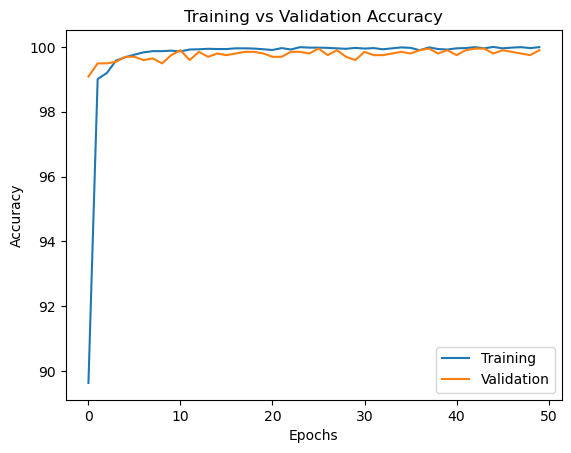

In [19]:
plt.plot(range(num_epochs),Accuracies,label="Training")
plt.plot(range(num_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

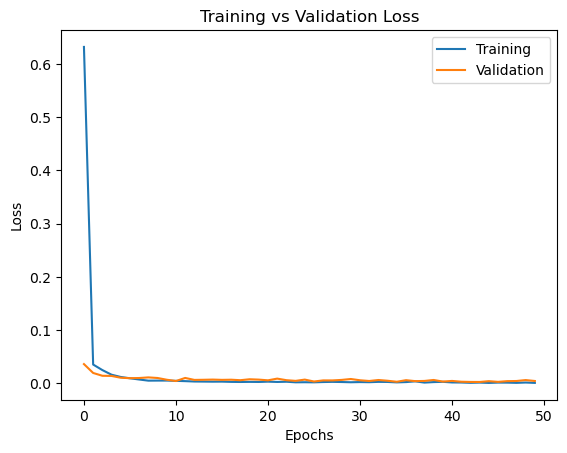

In [20]:
plt.plot(range(num_epochs),trainLoss,label="Training")
plt.plot(range(num_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [21]:
y_pred = []
y_true = []

for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

In [22]:
classes=classes[1:]

In [23]:
print(classes)

['Apple_healthy', 'Apple_unhealthy', 'Cherry_healthy', 'Cherry_unhealthy', 'Grape_healthy', 'Grape_unhealthy', 'Mango_healthy', 'Mango_unhealthy', 'Peach_healthy', 'Peach_unhealthy', 'Pepperbell_healthy', 'Pepperbell_unhealthy', 'Pomegranate_healthy', 'Pomegranate_unhealthy', 'Potato_healthy', 'Potato_unhealthy', 'Strawberry_healthy', 'Strawberry_unhealthy', 'Tomato_healthy', 'Tomato_unhealthy']


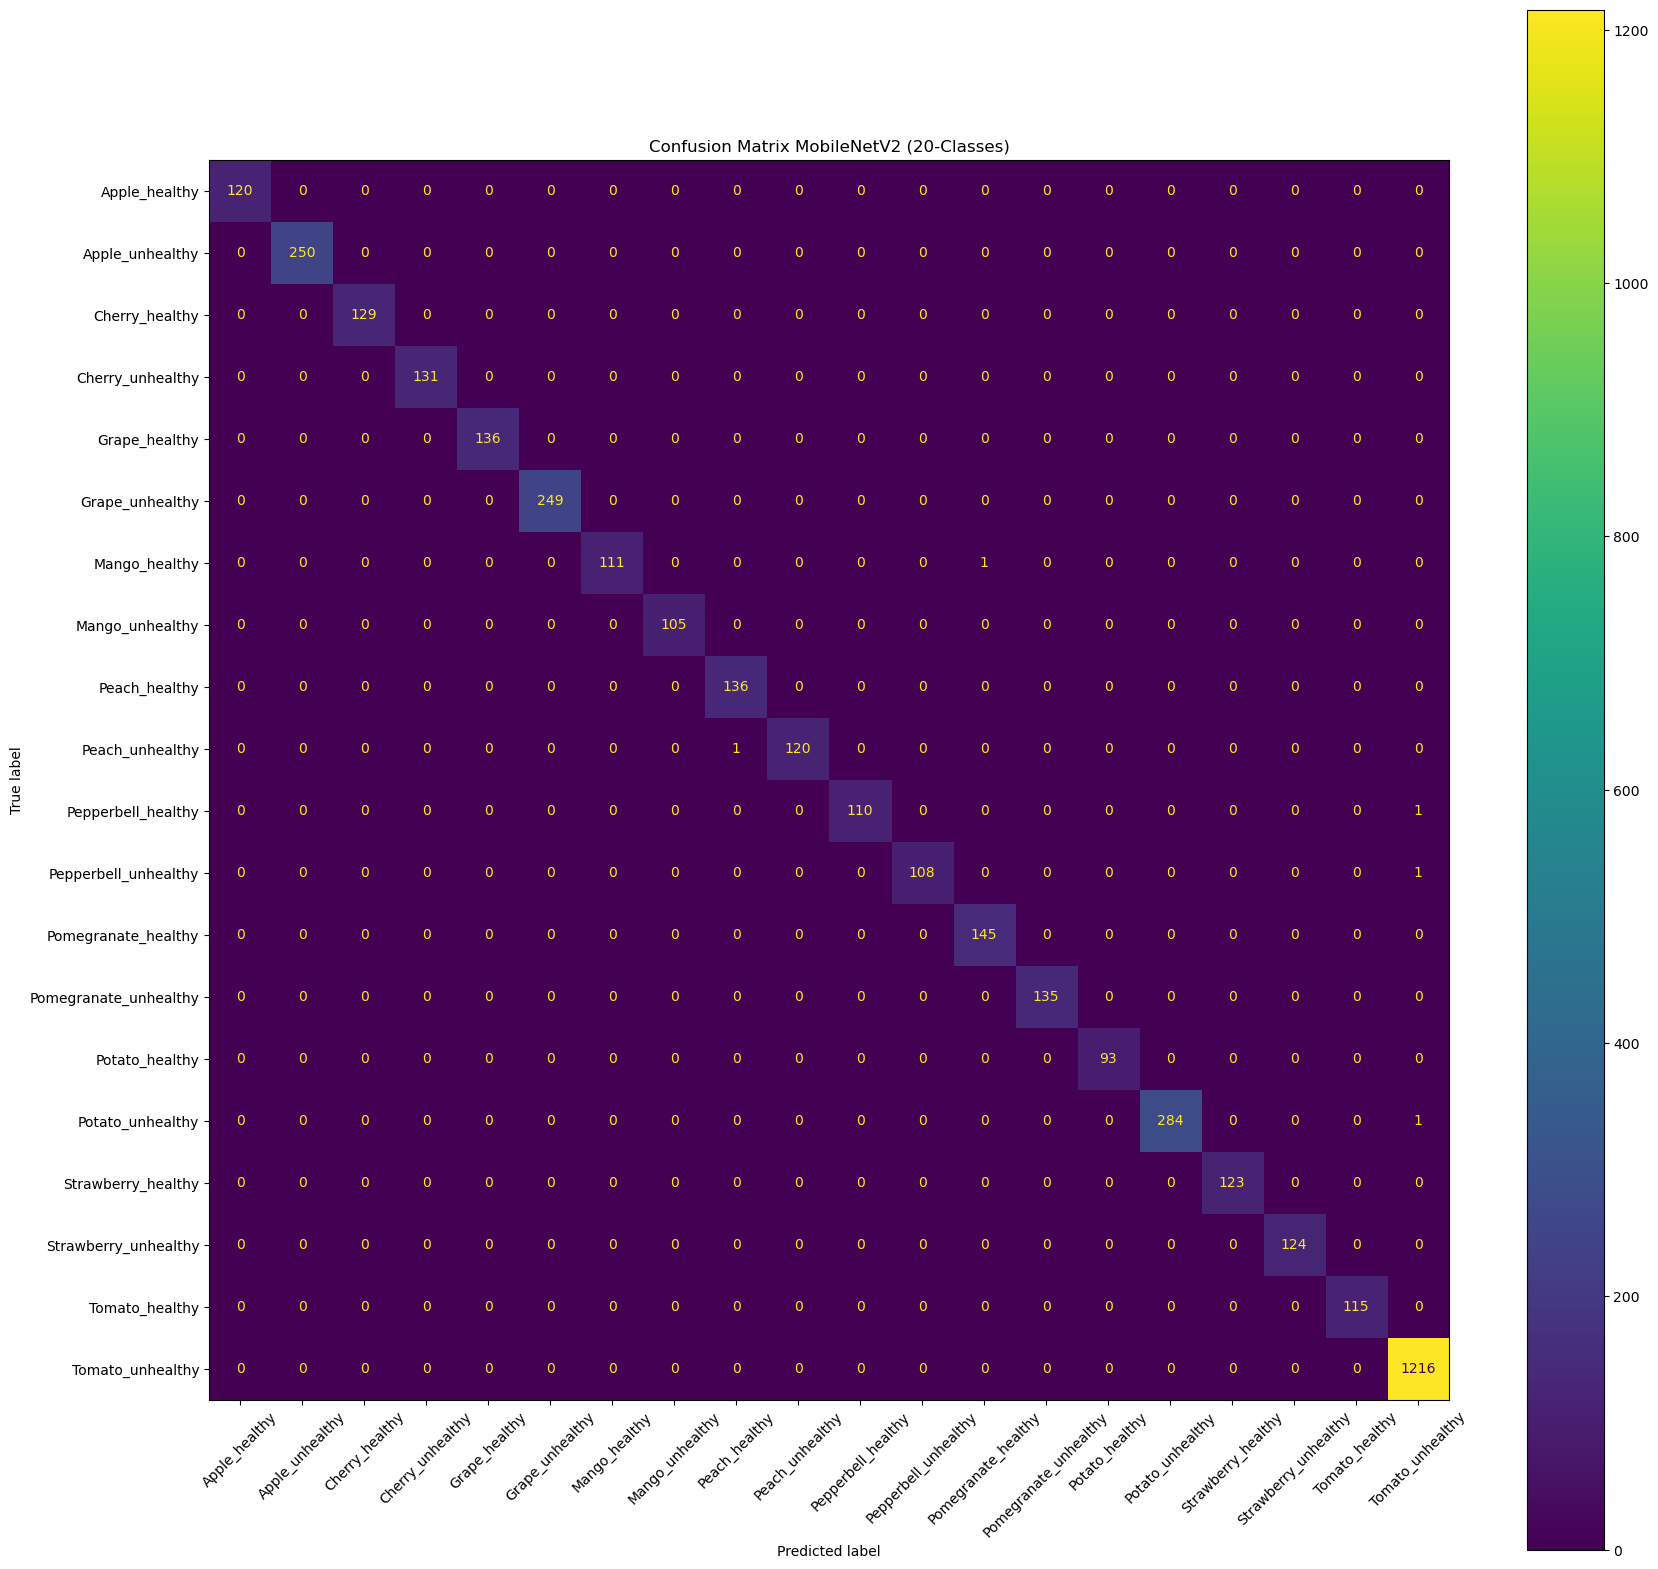

In [24]:
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(20,20)
plt.title("Confusion Matrix MobileNetV2 (20-Classes)")
disp.plot(ax=ax,xticks_rotation=45)
plt.show()

In [25]:
print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Precision Macro:1.00
Precision Micro:1.00
Recall Macro:1.00
Recall Micro:1.00
F1-Score Macro:1.00
F1-Score Micro:1.00
